In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import PolyCollection, LineCollection
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax import config
config.update("jax_enable_x64", True)

from scipy.linalg import svdvals

from data import generate_data
from loss import create_loss
from network import init_net_orth, compute_end_to_end, compute_factor
from solver import train
from utils import compose, svd

In [2]:
key = PRNGKey(0)

input_dim = 30
output_dim = 30
rank = 3
depth = 3
init_type = "orth"
init_scale = 1

key, subkey = split(key)
target = generate_data(key=subkey, shape=(output_dim, input_dim), rank=rank)

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=output_dim,
    width=input_dim,
    depth=depth,
    init_scale=init_scale
)

loss_fn = create_loss(target)
e2e_loss_fn = compose(loss_fn, compute_end_to_end)

In [3]:
n_outer_loops = 50
step_size = 1
result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    save_weights=True,
    n_inner_loops=1
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
def compute_angle(x, y):
    return jnp.arccos(jnp.clip(jnp.abs(jnp.dot(x, y)), 0, 1))

In [5]:
weights = result['weights']

m = input_dim - 2 * rank
Uinit, _, Vinit = svd(weights[1][0])

right_series = [[ *(input_dim * [0]) ]]
left_series = [[ *(input_dim * [0]) ]]
sval_series = [init_scale*jnp.ones(input_dim)]

for w in weights[1:]:
    Ut, st, Vt = svd(w[0])
    sval_series.append(st)
    
    Ut_top = Ut[:, :rank]
    Ut_mid = Ut[:, rank:-rank]
    Ut_bot = Ut[:, -rank:]
    
    Uinit_top = Uinit[:, :rank]
    Uinit_mid = Uinit[:, rank:-rank]
    Uinit_bot = Uinit[:, -rank:]
    
    Vt_top = Vt[:, :rank]
    Vt_mid = Vt[:, rank:-rank]
    Vt_bot = Vt[:, -rank:]
    
    Vinit_top = Vinit[:, :rank]
    Vinit_mid = Vinit[:, rank:-rank]
    Vinit_bot = Vinit[:, -rank:]
    
    right = []
    
    for k in range(rank):
        right.append(compute_angle(Vt_top[:, k], Vinit_top[:, k]))
    
    right += m * [0.]
    
    for k in range(rank):
        right.append(compute_angle(Vt_bot[:, k], Vinit_bot[:, k]))
        
    right_series.append(right)
        
    left = []
    
    for k in range(rank):
        left.append(compute_angle(Ut_top[:, k], Uinit_top[:, k]))
    
    left += m * [0.]
    
    for k in range(rank):
        left.append(compute_angle(Ut_bot[:, k], Uinit_bot[:, k]))
        
    left_series.append(left)
    
sval_series = jnp.array(sval_series)
right_series = jnp.array(right_series)
left_series = jnp.array(left_series)

In [17]:
def plot_sv_series(ax, series, color='viridis', spec_step=2):
    n_time_indices, n_sval_indices = series.shape
    time_indices = jnp.arange(n_time_indices)
    sval_indices = jnp.arange(n_sval_indices)

    spectrum_verts = []

    for idx in time_indices[::spec_step]:
        spectrum_verts.append([
            (0, jnp.min(series)-0.05), *zip(sval_indices, series[idx, :]), (n_sval_indices, jnp.min(series)-0.05)
        ])

    path_verts = []

    for idx in sval_indices:
        path_verts.append([
            *zip(time_indices, series[:, idx])
        ])

    spectrum_poly = PolyCollection(spectrum_verts)
    spectrum_poly.set_alpha(0.8)
    spectrum_poly.set_facecolor(plt.colormaps[color](jnp.linspace(0, 0.7, len(spectrum_verts))))
    spectrum_poly.set_edgecolor('black')

    path_line = LineCollection(path_verts)
    path_line.set_linewidth(1)
    path_line.set_edgecolor('black')
    
    ax.set_box_aspect(aspect=None, zoom=0.85)

    ax.add_collection3d(spectrum_poly, zs=time_indices[::spec_step], zdir='y')
    ax.add_collection3d(path_line, zs=sval_indices, zdir='x')

    ax.set_xlim(0, n_sval_indices)
    ax.set_ylim(0, n_time_indices)
    ax.set_zlim(jnp.min(series)-0.1, jnp.max(series)+0.1)

    elev = 30
    azim = -50
    roll = 0
    ax.view_init(elev, azim, roll)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

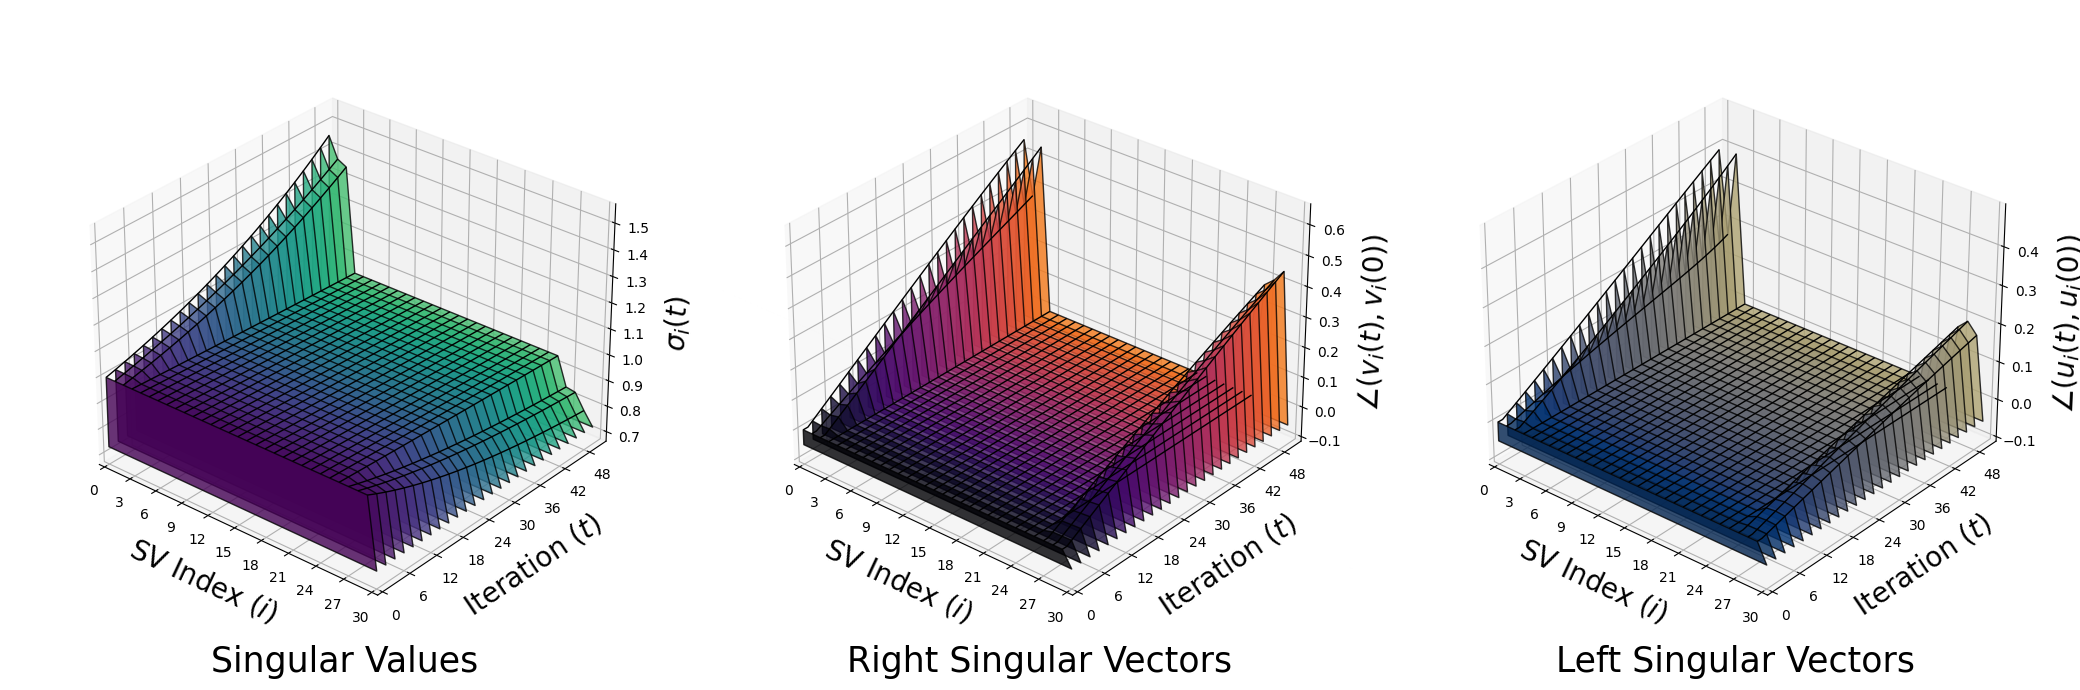

In [18]:
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
plot_sv_series(ax, sval_series)

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n$\sigma_i(t)$', fontsize=20)

ax.set_title('Singular Values', fontsize=25, y=0.0)

ax = fig.add_subplot(132, projection='3d')

plot_sv_series(ax, right_series, color='inferno')

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(v_i(t), v_i(0))$', fontsize=20)

ax.set_title('Right Singular Vectors', fontsize=25, y=0.0)

ax = fig.add_subplot(133, projection='3d')

plot_sv_series(ax, left_series, color='cividis')

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(u_i(t), u_i(0))$', fontsize=20)

ax.set_title('Left Singular Vectors', fontsize=25, y=0.0)

plt.tight_layout()
plt.savefig('figs/thm_main.png', dpi=300, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

plot_sv_series(ax, right_distances, color='inferno')

ax.set_xlabel('\nSV Index ($i$)', fontsize=15)
ax.set_xlim(0, n_sval_indices)
ax.set_ylabel('\nIteration ($t$)', fontsize=15)
ax.set_ylim(0, n_time_indices)
ax.set_zlabel('\n $\|v_i(t) v_i(t)^T - v_i(0) v_i(0)^T\|$', fontsize=13)

In [ ]:
# fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
# axes[0].imshow(jnp.log10(jnp.abs(U1.T @ init_weights[0] @ V1)), cmap='YlGn', vmax=1, vmin=-5)
# axes[0].set_title('Before Training', fontsize=15)
# axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

# pcm = axes[1].imshow(jnp.log10(jnp.abs(U1.T @ result['final_weights'][0] @ V1)), cmap='YlGn', vmax=1, vmin=-5)
# axes[1].set_title('After Training', fontsize=15)
# axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

# fig.colorbar(pcm, ax=axes.ravel().tolist())
# # plt.savefig('figs/thm_main.png', dpi=300, bbox_inches='tight')